In [16]:
!pip install plotly

You should consider upgrading via the '/home/victor/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as mpatches
%matplotlib inline

In [46]:
death_url =  "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
deaths_df = pd.read_csv(death_url, error_bad_lines=False)

cases_url =  "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
cases_df = pd.read_csv(cases_url, error_bad_lines=False)

states_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-08-2020.csv"
states_df = pd.read_csv(states_url, error_bad_lines=False)

# county_level = "https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv"
county_df = pd.read_csv('./covid19/small_abridged.csv', error_bad_lines=False)

In [47]:
deaths_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,5,5,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,97,97,99,99,102,107,108,111,113,114
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,4,4,4,4,4,4,4,4,5,6


# Data Cleaning
We took in the unabridged counties dataset, and selected useful columns outside of this notebook.

In [102]:
#drop territories
cases = cases_df[~cases_df['Admin2'].isnull()] 
#drop those without FIPS-we thought this is acceptable because most are not actually counties, and there's only 10 of them
cases = cases[~cases['FIPS'].isnull()] 
#change FIPS to integer type
cases['FIPS'] = cases['FIPS'].astype(int)
#Only dealing with states, so county is better name
cases = cases.rename(columns={'Admin2':'County'}) 
#the country is US, unnecessary
cases = cases.drop(columns=['Country_Region'])
cases.head()

#repeat for deaths

#drop territories
deaths = deaths_df[~deaths_df['Admin2'].isnull()] 
#drop those without FIPS-we thought this is acceptable because most are not actually counties, and there's only 10 of them
deaths = deaths[~deaths['FIPS'].isnull()] 
#change FIPS to integer type
deaths['FIPS'] = deaths['FIPS'].astype(int)
#Only dealing with states, so county is better name
deaths = deaths.rename(columns={'Admin2':'County'})
deaths.head()

county = county_df.rename(columns={'countyFIPS':'FIPS', 'CountyName':'County'}).drop(columns=['Unnamed: 0'])
# drop rows that are not counties. There's only two: NYC and Kansas City, so shouldn't matter much
county = county[county['FIPS'].str.isnumeric()]
county['FIPS'] = county['FIPS'].astype(int)
county.head()

county_cases_deaths = pd.read_csv('county_info_cases_deaths.csv')
county_cases_deaths.head(3)


,Unnamed: 0,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,...,5/1/20_cases,5/2/20_cases,5/3/20_cases,5/4/20_cases,5/5/20_cases,5/6/20_cases,5/7/20_cases,5/8/20_cases,5/9/20_cases,5/10/20_cases
0,0,1001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,...,42,45,48,53,53,58,61,67,68,74
1,1,1003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,...,175,181,187,188,189,196,205,208,216,222
2,2,1005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,...,42,43,45,45,47,47,51,53,58,59


The following functions make it easy to combine the time series of cases with county data. The following outputs state coronavirus cases/deaths, with the granularity of counties, and merged with county demographic data found in the unabridged county dataset.

In [49]:
def create_state_cases_with_county_data(state):
    state_counties = county[county['State'] == state]
    state_cases = cases[cases['Province_State'] == state]
    state_cases = state_counties.merge(state_cases, right_on='FIPS', left_on='FIPS', how='right', validate='one_to_many')
    return state_cases[~state_cases['County_x'].isna()]

def create_state_deaths_with_county_data(state):
    state_counties = county[county['State'] == state]
    state_deaths = deaths[deaths['Province_State'] == state]
    state_deaths = state_counties.merge(state_deaths, right_on='FIPS', left_on='FIPS', how='right', validate='one_to_many')
    return state_deaths[~state_deaths['County_x'].isna()]

california_cases = create_state_cases_with_county_data('California')
california_deaths = create_state_deaths_with_county_data('California')

# Exploratory Data Analysis
### Finding promising factors that are related to COVID-19 cases or fatalities

In [51]:
def date_columns(df, not_date_columns=False):
    """returns list of column names if they don't match regex for a date (filters out time series)"""
    columns = df.columns.str.contains(r'\d\/[\d]{1,2}\/\d\d')
    if not_date_columns:
        return [x for x in (~columns)*df.columns.values if x]

    return [x for x in columns*df.columns.values if x]

def find_correlations(df, correlate_with, columns_to_avoid='Default', highest_n=15):
    #Following columns are mostly population (and repeat info), must be normalized before correlating
    if columns_to_avoid == 'Default':
        columns_to_avoid = ['PopMale<52010', 'PopFmle<52010',
               'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
               'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
               'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
               'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
               'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
               'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
               'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
               'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
               'PopMale>842010', 'PopFmle>842010',  'PopTotalMale2017',
                'PopTotalFemale2017','3-YrMortalityAge<1Year2015-17',
                '3-YrMortalityAge1-4Years2015-17',
                '3-YrMortalityAge5-14Years2015-17',
                '3-YrMortalityAge15-24Years2015-17',
                '3-YrMortalityAge25-34Years2015-17',
                '3-YrMortalityAge35-44Years2015-17',
                '3-YrMortalityAge45-54Years2015-17',
                '3-YrMortalityAge55-64Years2015-17',
                '3-YrMortalityAge65-74Years2015-17',
                '3-YrMortalityAge75-84Years2015-17',
                '3-YrMortalityAge85+Years2015-17',  'Poverty Num All Ages 2018',
                'Poverty Num Ages 0-17 2018',
                'Poverty Num Ages 5-17 2018',
                'mortality2015-17Estimated',
                '3-YrDiabetes2015-17', 
                "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', 
                '#Hospitals', '#ICU_beds', 'MedicareEnrollment,AgedTot2017',
                'HPSAUnderservedPop', 'HPSAUnderservedPop.1', 'HPSAServedPop',
                'HPSAPercentPoverty', 'StrokeMortality', 'lon', 'Long_', 'lat', 'Lat',
                '#EligibleforMedicare2018', '#FTEHospitalTotal2017', 'PopulationEstimate65+2017',
                'Population', 'CensusPopulation2010']
    # ignore the dates as well
    columns_to_avoid += date_columns(df)
    # only correlate with quantitative variables
    numerics = df.select_dtypes(include=[np.number])
    corr, log_normal_corr, log_log_corr, normal_log_corr = [], [], [], []
    correlate_with_logged = np.log(correlate_with)
    # loop through all columns, calculating correlations
    for col in numerics:
        column = df[col]
        if col in columns_to_avoid or np.mean(column.isna()) > 0.5: # skip if to_avoid or is mostly nan
            continue
        corr.append((col, column.corr(correlate_with)))
        log_normal_corr.append((col, np.log(column).corr(correlate_with)))
        log_log_corr.append((col, np.log(column).corr(correlate_with_logged)))
        normal_log_corr.append((col, column.corr(correlate_with_logged)))
        
    def highest_n_columns(corrs):
        """ Return list of length highest_n, of tuples containing column name, correlation,
        sorted descending by abs(correlation)"""
        return sorted([x for x in corrs if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:highest_n]
    corr = highest_n_columns(corr)
    log_normal_corr = highest_n_columns(log_normal_corr)
    log_log_corr = highest_n_columns(log_log_corr)
    normal_log_corr = highest_n_columns(normal_log_corr)
    return corr, log_normal_corr, log_log_corr, normal_log_corr

In [52]:
def plot_correlations(df, corrs, corr_with, title):
    """create scatter plot between corrs columns and corr_with column, with line of best fit"""
    fig, axes = plt.subplots((len(corrs) + 2)//3, 3, figsize=(15, 17))
    for i in range(len(corrs)):
        col = corrs[i][0]
        ax = axes[i//3][i%3]
        x=df[col]
        y=corr_with
        sns.regplot(x=x,
                    y=y,
                    ax=ax,
                    fit_reg=True
                   )
        ax.set_title("Correlation: {}".format(x.corr(y).round(3)))
        ax.set_ylim(bottom=np.min(y) - np.std(y)/2, top=np.max(y) + np.std(y)/2)
        ax.set_xlim(left=np.min(x) - np.std(x)/2, right=np.max(x) + np.std(x)/2)
        ax.set_ylabel('County Coronavirus Cases per Capita')
        ax.set_xlabel(col, fontsize=18)

    fig.suptitle(title, fontsize=25)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



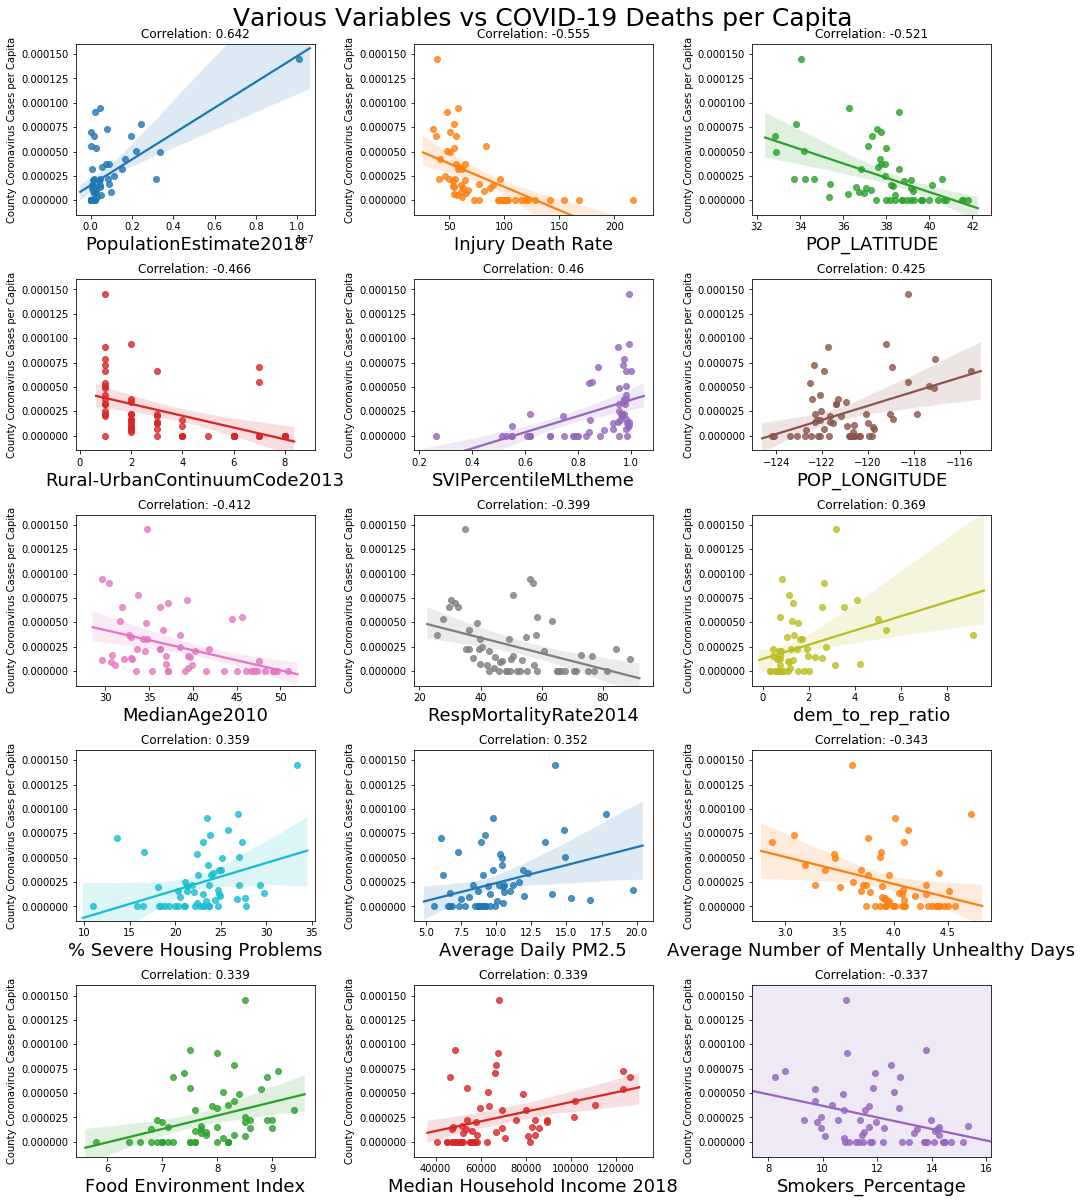

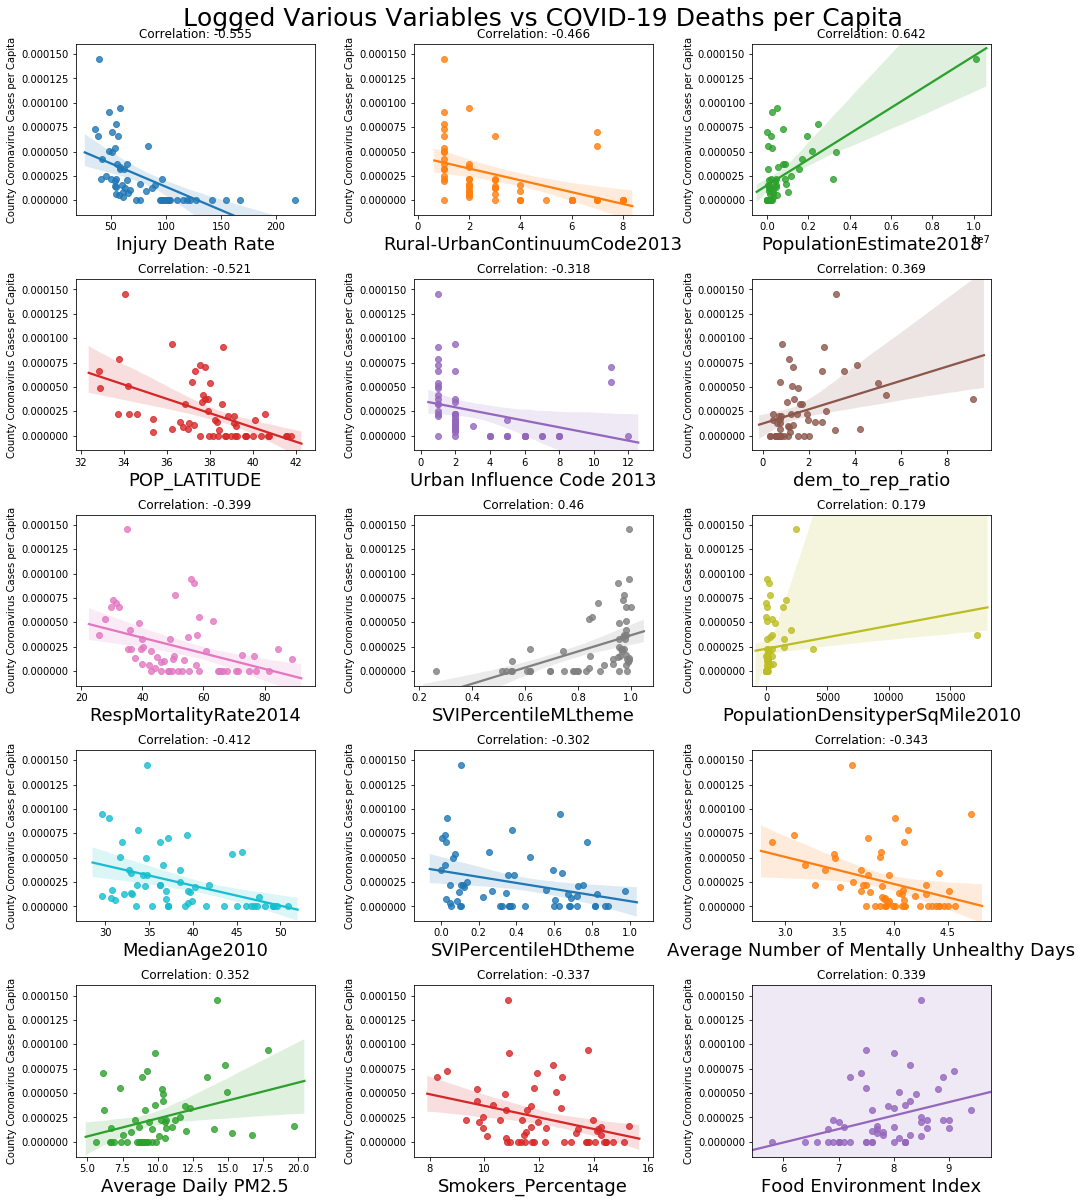

In [93]:
#Death Correlations
deaths_per_capita=california_deaths['5/8/20']/california_deaths['PopulationEstimate2018']
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(california_deaths, deaths_per_capita)
# Plot variables vs covid deaths per capita. Each point is a county
plot_correlations(california_deaths, corr, deaths_per_capita, title="Various Variables vs COVID-19 Deaths per Capita")
# Plot the log of variables vs covid deaths per capita. Each point is county
plot_correlations(california_deaths, log_normal_corr, deaths_per_capita, title="Logged Various Variables vs COVID-19 Deaths per Capita")

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



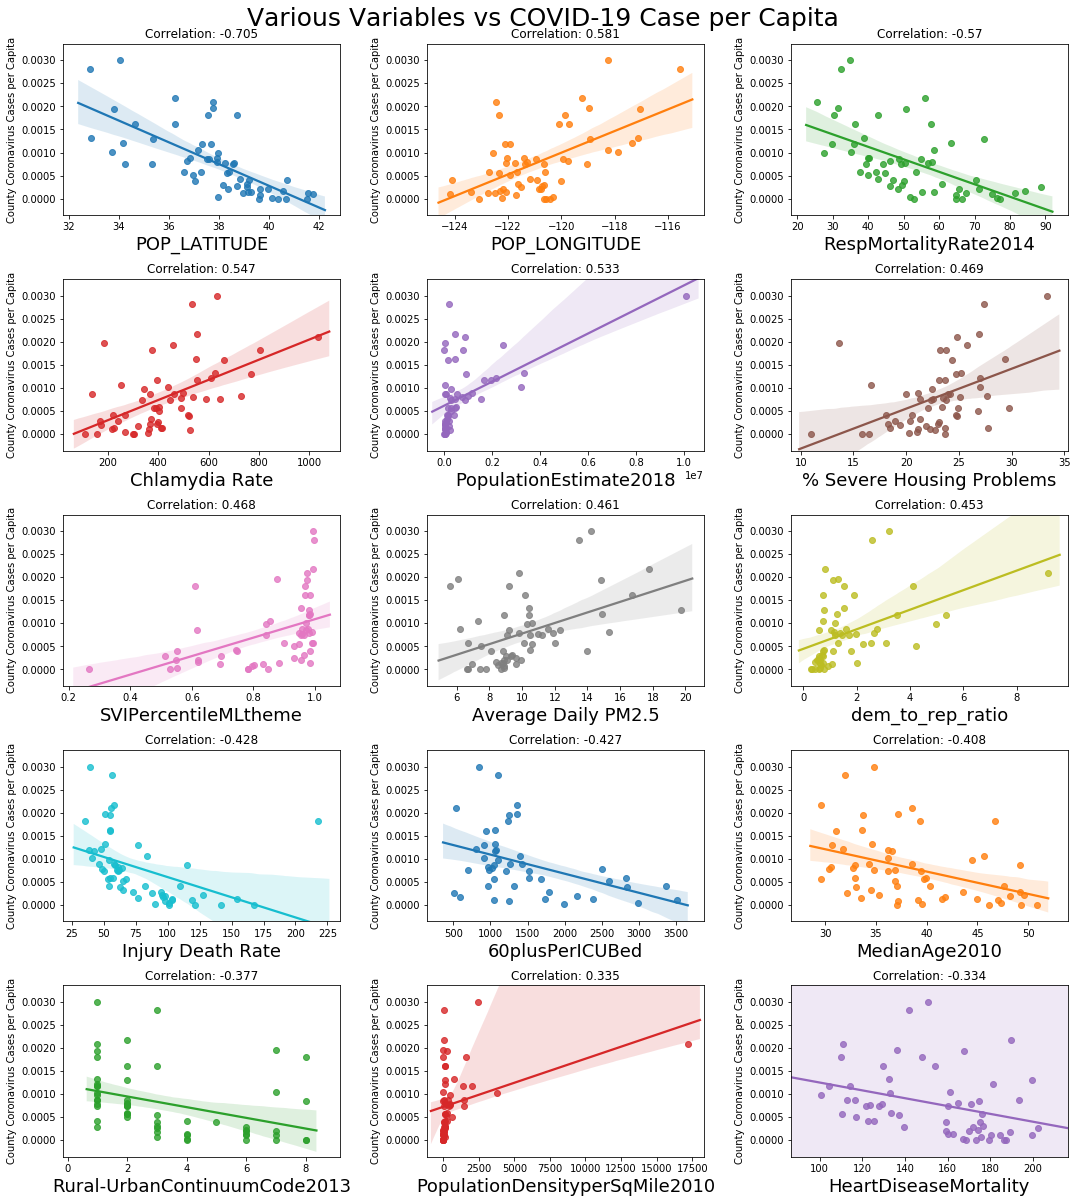

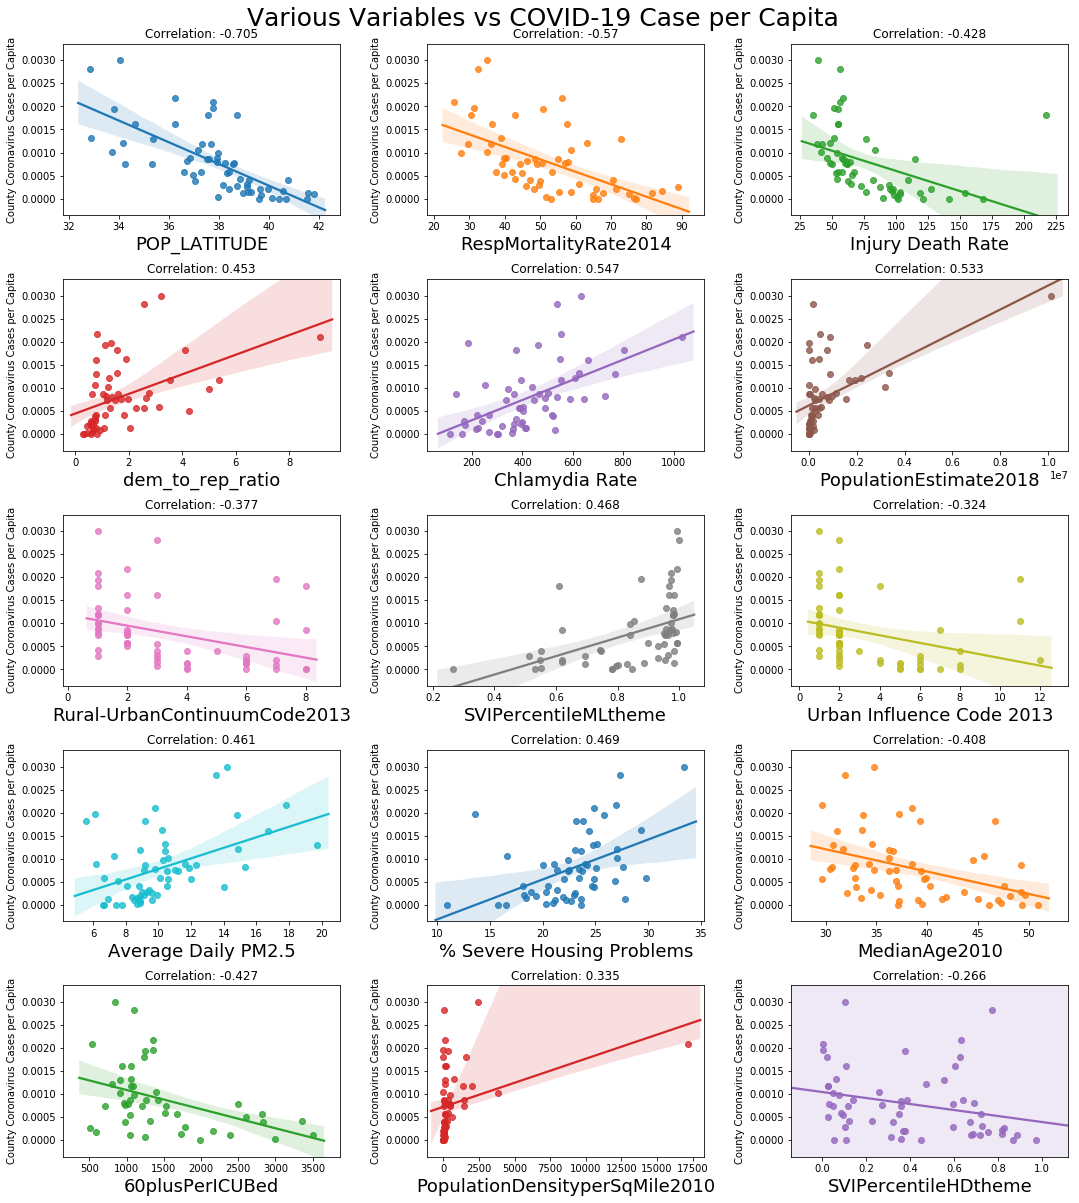

In [103]:
#Cases Correlations
cases_per_capita = california_cases['5/8/20']/california_cases['PopulationEstimate2018']
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(california_cases, cases_per_capita)
# Plot variables vs covid cases per capita. Each point is a county
plot_correlations(california_cases, corr, cases_per_capita, title="Various Variables vs COVID-19 Case per Capita")
# Plot log of variables vs covid deaths per capita. Each point is a county
plot_correlations(california_cases, log_normal_corr, cases_per_capita, title="Various Variables vs COVID-19 Case per Capita")

### Cases doubling rate
Another useful metric is the number of days that it takes for number of cases (active cases for our calculations) to double. This is useful because the infections per day relies too heavily on how many infections there were a couple of days ago. For simplicity, we calculated active cases as the number of new cases from the past 14 days.

In [97]:
# Filter out the counties with a good number of cases already (if not, the doubling rate is likely not accurate or helpful)
hundred_plus_infections = california_cases[california_cases['5/12/20'] > 100]

# Find the infection rate, smoothed over by taking a moving average over the previous 5 days
dates = date_columns(hundred_plus_infections)
infections_rate_smoothed = hundred_plus_infections[dates].diff(axis=1).rolling(5, axis=1).mean()

# To find active cases, subtract each number of cases in each column from the number of cases from 14 columns (days) prior
new_cases_last_14_days = hundred_plus_infections[dates].iloc[:,14:] - hundred_plus_infections[dates].iloc[:,:-14].values

# To get doubling rate, divide active cases by the infection rate. We are only interested in the recent doubling rate
doubling_days = (new_cases_last_14_days/infections_rate_smoothed.iloc[:,14:]).iloc[:,-30:]
doubling_days.head(3)

,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20
0,14.135514,13.434579,16.439394,16.119403,14.220183,14.845133,10.833333,13.209607,12.970085,15.865922,...,13.541667,14.014423,13.786408,13.678414,13.388626,13.160377,11.821862,11.647059,12.626050,13.888889
6,20.277778,25.000000,17.596154,18.861386,15.642202,14.210526,10.886525,15.760870,13.008475,13.086957,...,12.233010,14.117647,14.102564,14.230769,17.615385,16.521739,12.977528,14.620253,18.095238,16.716418
9,14.363636,12.803030,11.730769,12.364865,10.691489,9.590909,11.397849,16.171875,13.197674,14.802632,...,11.777778,16.736842,11.977612,12.530864,11.049383,10.277778,9.567308,10.023474,14.494048,11.739130


/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


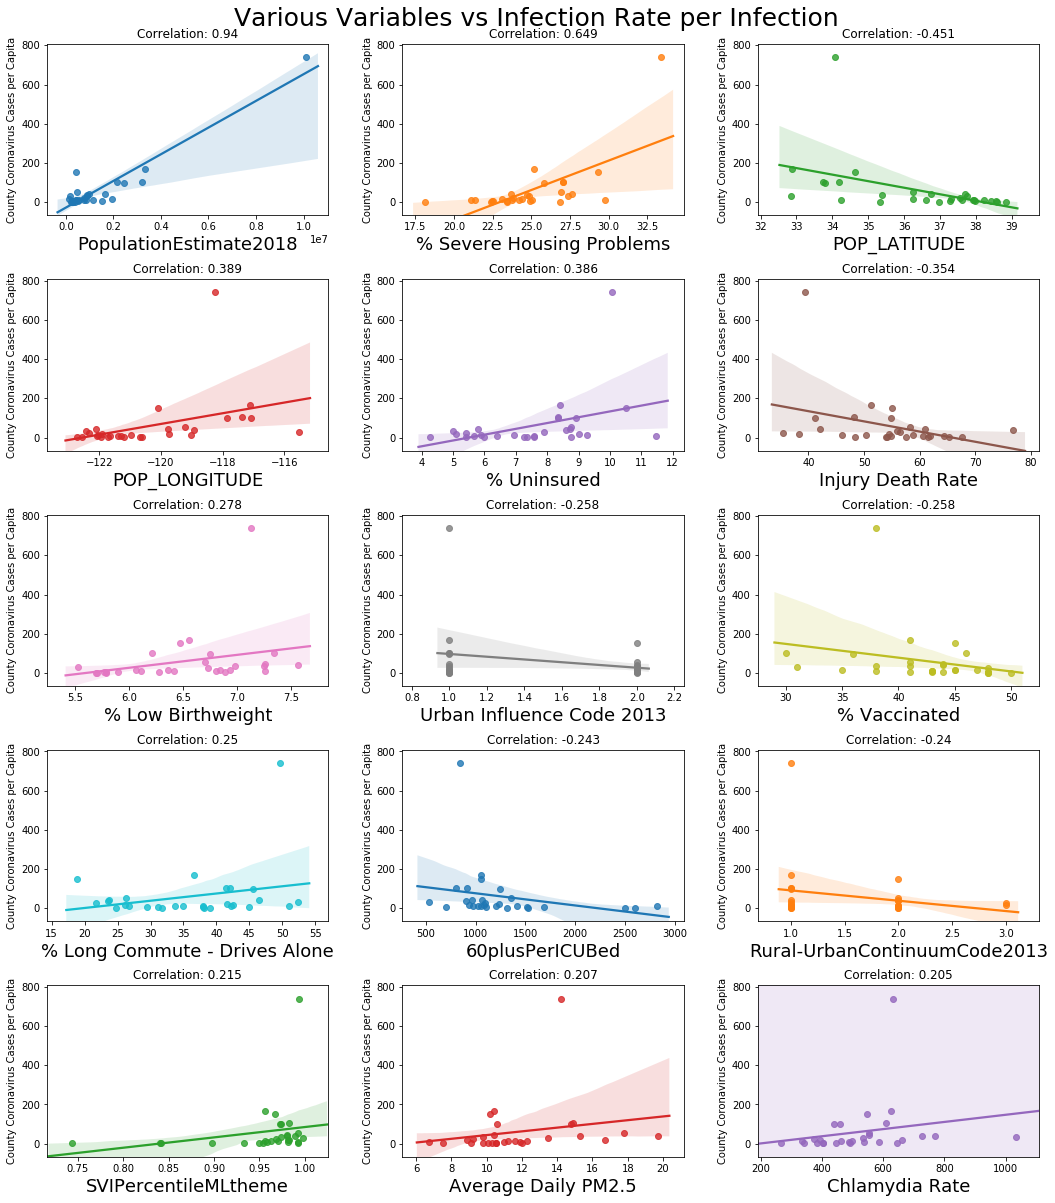

In [56]:
# Get current doubling rate
cases_doubling_rate  = infections_rate_smoothed['5/12/20']

# Find correlations between county demographics and doubling rate, plot.
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(hundred_plus_infections, cases_doubling_rate)
plot_correlations(hundred_plus_infections, corr, cases_doubling_rate, title="Various Variables vs Infection Rate per Infection")

# PCA
Run PCA on just the cases for a CA. These methods can be easily replicated for any other state.

In [99]:
dates = date_columns(california_cases)

#take just the cases, and normalize by population
ca = california_cases[dates].div(california_cases['PopulationEstimate2018'], axis=0)
#center and standardize the variance
ca = ((ca - ca.mean())/np.std(ca)).drop(columns=['1/22/20', '1/23/20', '1/24/20', '1/25/20'])
#PCA!
u, s, vt = np.linalg.svd(ca, full_matrices=False)
#Put the first 10 PC into a dataframe
pc_df = pd.DataFrame((u @ np.diag(s))[:,:10], columns=['pc%d' % i for i in range(1, 11)])

#Calculate the percent variance that can be explained by the first PC1.
total_variance_computed_from_singular_values = np.sum(s**2)/ca.shape[0]
total_variance_computed_from_data = sum(np.var(ca, axis=0))
variance_explained_by_1st_pc = ((s[0]**2)/ca.shape[0])/total_variance_computed_from_data
variance_explained_by_1st_pc

0.4434204007737842

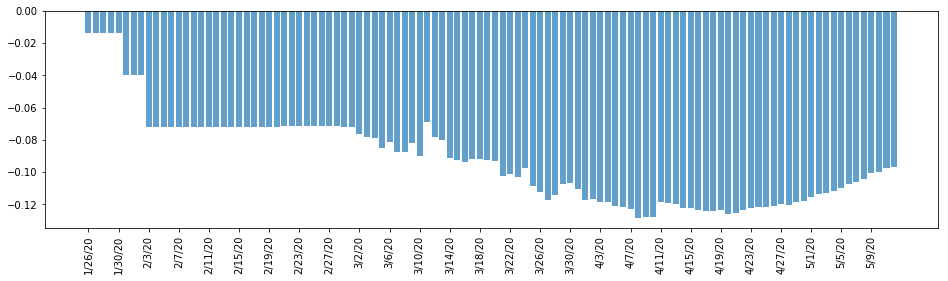

In [62]:
#See which dates most affect the first principal component
#Taken from HW8
def plot_pc(col_names, vt, k):
    plt.bar(col_names, vt[k, :], alpha=0.7)
    plt.xticks(col_names[::4], rotation=90);
with plt.rc_context({"figure.figsize": (16, 4)}): 
    plot_pc(list(ca.columns), vt, 0);

### Plot the Counties by the largest two principal components
We can see that there is an outlier, San Benito, and there seems to be two distinct clusters, which we will explore later

In [65]:
fig = px.scatter(data_frame=pc_df, x='pc1', y='pc2', text=list(california_cases['County_x']))
fig.update_traces(textposition='top center')
fig.update_layout(
    height=600,
    title_text='pc1 vs pc2'
)

fig.show()

Here's the same plot, but with a third dimension: pc3!

In [100]:
fig = px.scatter_3d(data_frame=pc_df, x='pc1', y='pc2', z='pc3', text=list(california_cases['County_x']))
fig.update_traces(textposition='top center')
fig.update_layout(
    height=600,
    title_text='pc1 vs pc2 vs pc3'
)

fig.show()

Visually, we then isolated each cluster, and took the original cases time series data and plotted it to see the differences

In [101]:
temp = california_cases.copy()
#take only the cases by day and normalize based off of the population
temp = temp[dates].div(temp['PopulationEstimate2018'], axis=0)

#cluster0 is the outlier, San Benito, and from eye has pc2 less than 20
cluster0 = temp.iloc[pc_df[pc_df['pc2'] < -20].index]
#cluster1 is the cluster on the left
cluster1 = temp.iloc[pc_df[(pc_df['pc1'] < -10) & (pc_df['pc2'] > -20)].index]
#cluster2 is the group on the right
cluster2 = temp.iloc[pc_df[pc_df['pc1'] > -10].index]

The below plot is the beginning of the spread in California, with each county a line, colored by cluster, the first 40 days after 1/23/20. As we can see, the outlier is San Benito in blue, which had a massive per capita spike in infections (or testing).

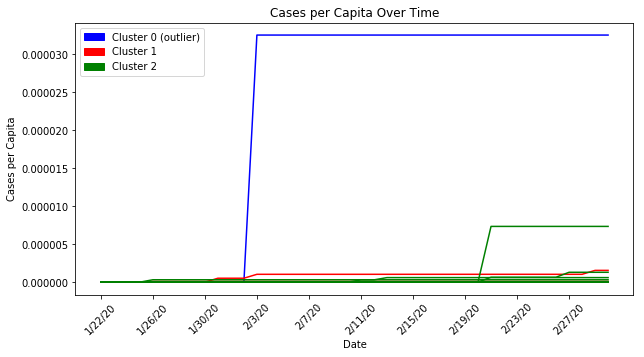

In [87]:
red_patch = mpatches.Patch(color='red', label='Cluster 1')
blue_patch = mpatches.Patch(color='blue', label='Cluster 0 (outlier)')
green_patch = mpatches.Patch(color='green', label='Cluster 2')

plt.figure(figsize=(10,5))
plt.plot(cluster0.T.drop(cluster1.columns.values[40:]), color='blue', label='cluster0')
plt.plot(cluster1.T.drop(cluster1.columns.values[40:]), color='red', label='cluster1')
plt.plot(cluster2.T.drop(cluster1.columns.values[40:]), color='green', label='cluster2')
plt.title('Cases per Capita Over Time')
plt.xlabel('Date')
plt.ylabel('Cases per Capita')
plt.xticks(cluster1.columns.values[:40:4], rotation=45)
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.show()

The following is the rest of the spread, and it's clear that the red cluster, with smaller pc1 and higher pc2, tends to be more hard hit by the pandemic (especially in the middle). 

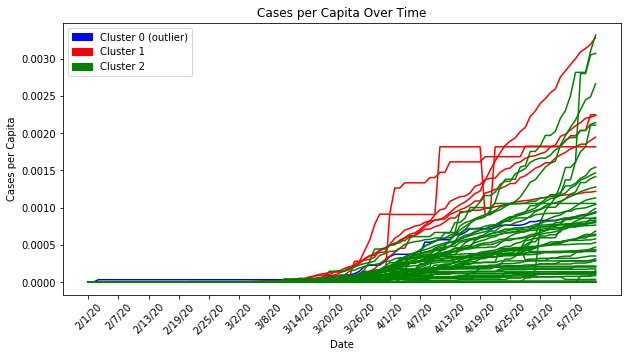

In [89]:
plt.figure(figsize=(10,5))
red_patch = mpatches.Patch(color='red', label='Cluster 1')
blue_patch = mpatches.Patch(color='blue', label='Cluster 0 (outlier)')
green_patch = mpatches.Patch(color='green', label='Cluster 2')
plt.plot(cluster0.T.drop(cluster1.columns.values[:10]), color='blue')
plt.plot(cluster1.T.drop(cluster1.columns.values[:10]), color='red')
plt.plot(cluster2.T.drop(cluster1.columns.values[:10]), color='green')
plt.title('Cases per Capita Over Time')
plt.xlabel('Date')
plt.ylabel('Cases per Capita')
plt.xticks(cluster1.columns.values[10::6], rotation=45)
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.show()